# Longitudinal profile of 3D clusters

In [55]:
import sys
from dataclasses import dataclass
from enum import Enum, auto
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [36]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v28'
clueParams = "single-file"
#clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data"}

In [37]:
(histStore
        .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy_IntervalLength", clueParams, "data"))
        .getHistogram(HistogramKind.COUNT)
    )

Hist(
  IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'),
  StrCategory(['allTracksters', 'mainTrackster'], name='mainOrAllTracksters', label='For 3D clusters, whether to consider for each event all 3D clusters (allTracksters) or only the highest energy 3D cluster (mainTrackster)'),
  Integer(1, 10, name='clus3D_size', label='3D cluster size ie number of 2D clusters that make out this 3D cluster'),
  StrCategory(['0.68', '0.9', '0.95'], name='intervalEnergyFraction', label='Computing the shortest interval that holds at least this fraction of 3D cluster energy'),
  Integer(0, 30, name='intervalFractionEnergy_length', label='Number of layers of smallest interval holding at least fraction of 3D cluster energy'),
  storage=Double()) # Sum: 444.0 (12759.0 with flow)

In [38]:
@dataclass
class PlotInfo:
    beamEnergy:int|None
    datatype:str
    histName:str = None
    projectOn:str = None
    intervalEnergyFraction:str|list[str]|None = None
    

In [39]:
def getHist(info:PlotInfo):
    projections = {
        "mainOrAllTracksters" : hist.loc("mainTrackster"),
        # Project on clus3D_size
    }
    if info.beamEnergy is not None:
        projections["beamEnergy"] = hist.loc(info.beamEnergy)
    if info.intervalEnergyFraction is not None:
        projections["intervalEnergyFraction"] = hist.loc(info.intervalEnergyFraction)
    return (histStore
        .get(HistogramId(info.histName, clueParams, info.datatype))
        .getHistogram(HistogramKind.COUNT)[projections]
        .project(info.projectOn)
    )

In [40]:
getHist(PlotInfo(datatype="data", beamEnergy=20, intervalEnergyFraction="0.9", histName="Clus3DIntervalHoldingFractionOfEnergy_IntervalLength", projectOn="intervalFractionEnergy_length"))

Hist(Integer(0, 30, name='intervalFractionEnergy_length', label='Number of layers of smallest interval holding at least fraction of 3D cluster energy'), storage=Double()) # Sum: 2007.0

In [41]:
def makePlotSimple(plotInfo:PlotInfo):
    """ Plot distribution of length of layers holding fraction of 3D clustered energy, for different fractions"""
    if plotInfo.histName is None:
        plotInfo.histName = "Clus3DIntervalHoldingFractionOfEnergy_IntervalLength"
    if plotInfo.projectOn is None:
        plotInfo.projectOn = "intervalFractionEnergy_length"
    if type(plotInfo.intervalEnergyFraction) is list:
        h = []
        labels = []
        for fraction in plotInfo.intervalEnergyFraction:
            individualPlotInfo = copy.copy(plotInfo)
            individualPlotInfo.intervalEnergyFraction = fraction
            h.append(getHist(individualPlotInfo))
            labels.append(f"{float(fraction):.0%} of cluster energy")
    else:
        h = getHist(plotInfo)
        labels = None

    plt.figure()
    plt.xlabel("Layer length")
    plt.ylabel("Event count")
    
    hep.histplot(h, yerr=False, label=labels)

    plt.xlim(0, 20)
    if plotInfo.datatype == "data":
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ " + str(plotInfo.beamEnergy) + " GeV")
    plt.legend()

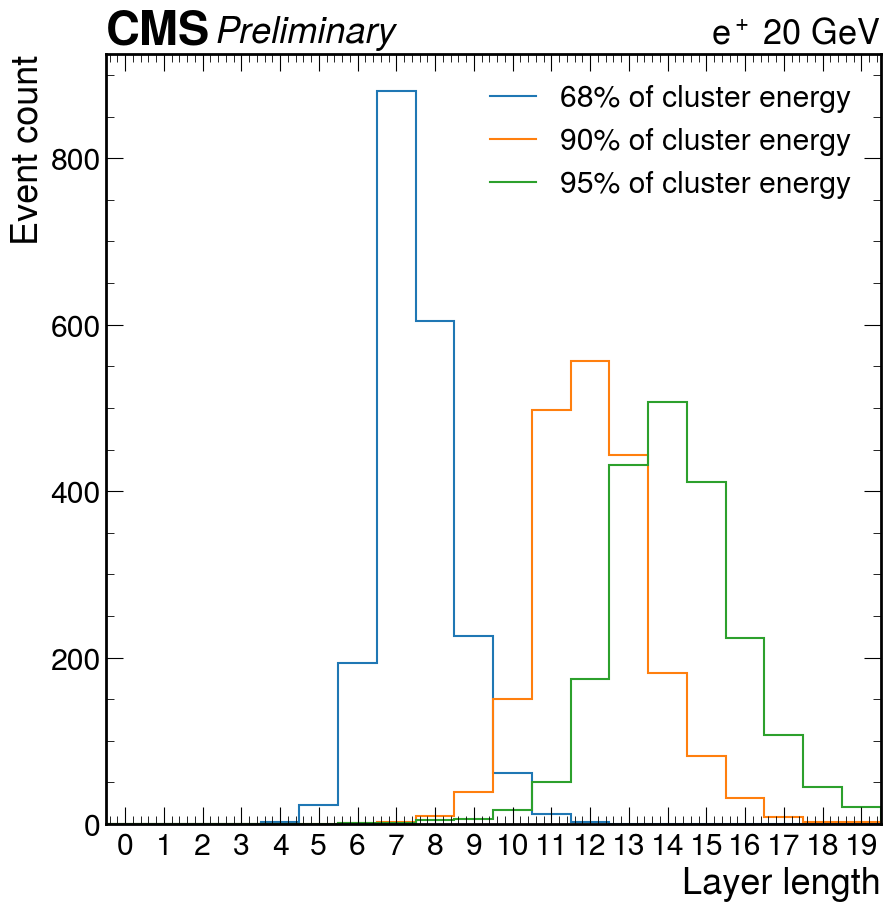

In [42]:
makePlotSimple(PlotInfo(beamEnergy=20, datatype="data", intervalEnergyFraction=["0.68", "0.9", "0.95"]))

In [43]:
h = getHist(PlotInfo(datatype="data", beamEnergy=20, intervalEnergyFraction=None, histName="Clus3DIntervalHoldingFractionOfEnergy_MeanIntervalLength", projectOn="intervalEnergyFraction"))
h

Hist(StrCategory(['0.68', '0.9', '0.95'], name='intervalEnergyFraction', label='Computing the shortest interval that holds at least this fraction of 3D cluster energy'), storage=Double()) # Sum: 6021.0

In [44]:
(histStore
    .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy_MeanIntervalLength", clueParams, "data"))
    .getHistogram(HistogramKind.PROFILE)[{
        "mainOrAllTracksters" : hist.loc("mainTrackster"),
        # Project on clus3D_size
        #"intervalEnergyFraction" : hist.loc("0.9"),
        "beamEnergy" : hist.loc(20),
    }]
    .project("intervalEnergyFraction")
)

Hist(StrCategory(['0.68', '0.9', '0.95'], name='intervalEnergyFraction', label='Computing the shortest interval that holds at least this fraction of 3D cluster energy'), storage=Mean()) # Sum: Mean(count=6021, value=11.2948, variance=9.92421)

In [47]:
def makePlotProfile_fctBeamEnergy(intervalEnergyFraction:str, datatypes):
    """ Plot mean of interval length holding fraction of energy, as a function of beam energy"""
    hists = [(histStore
        .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy_MeanIntervalLength", clueParams, datatype))
        .getHistogram(HistogramKind.PROFILE)[{
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "intervalEnergyFraction" : hist.loc(intervalEnergyFraction),
            #"beamEnergy" : hist.loc(20),
        }]
        .project("beamEnergy")
        ) for datatype in datatypes]
    labels = [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]
    
    plt.figure()
    plt.xlabel("Nominal beam energy (GeV)")
    plt.ylabel("Event count")
    
    hep.histplot(hists, yerr=False, label=labels, histtype="errorbar", linestyle="-")

    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ beam")
    plt.legend()

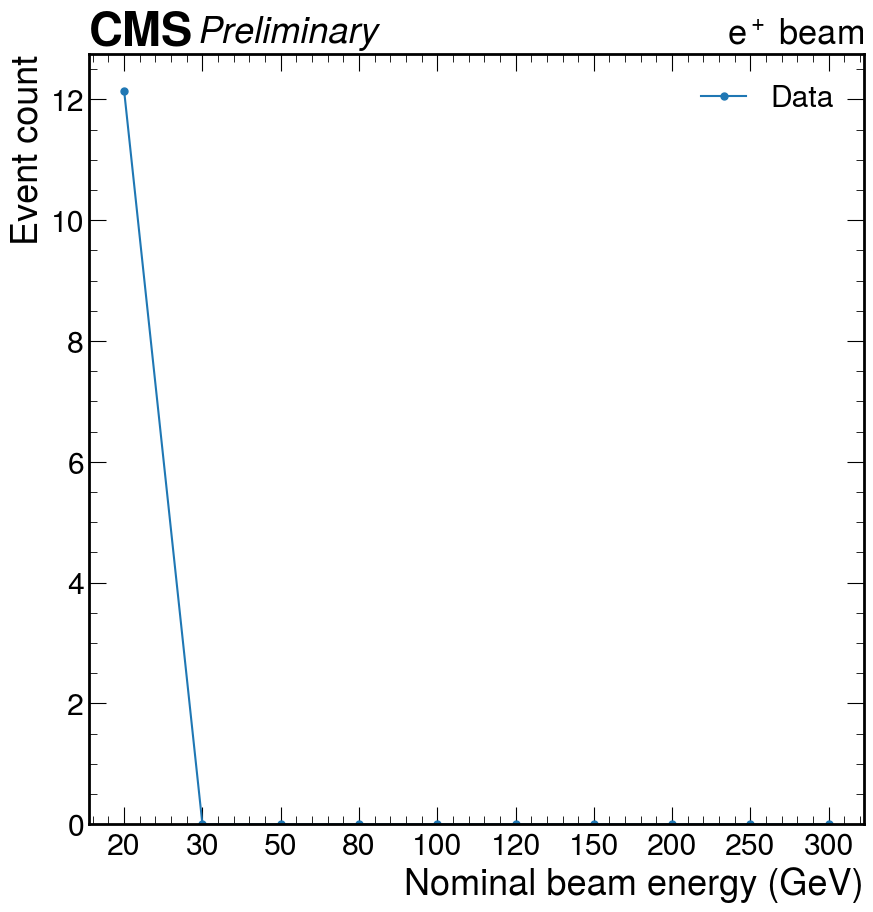

In [48]:
makePlotProfile_fctBeamEnergy("0.9", ["data"])

In [91]:
def makePlotProfile_fctFraction(beamEnergy, datatypes):
    """ Plot mean of interval length holding fraction of energy, as a function of beam energy"""
    hists = [(histStore
        .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy_MeanIntervalLength", clueParams, datatype))
        .getHistogram(HistogramKind.PROFILE)[{
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            #"intervalEnergyFraction" : hist.loc(intervalEnergyFraction),
            "beamEnergy" : hist.loc(beamEnergy),
        }]
        .project("intervalEnergyFraction")
        ) for datatype in datatypes]
    labels = [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Fraction of energy")

    # This does not work as mplhep.histplot already uses a TickFormatter to plot categories
    # Would need to somehow merge the two
    #ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0))
    
    ax.set_ylabel("Number of layers holding fraction of cluster energy")
    
    hep.histplot(hists, ax=ax, yerr=False, label=labels, histtype="errorbar", linestyle="-")
    

    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=ax)
    hep.cms.lumitext("$e^+$ " + str(beamEnergy) + " GeV", ax=ax)
    ax.legend()
    return fig

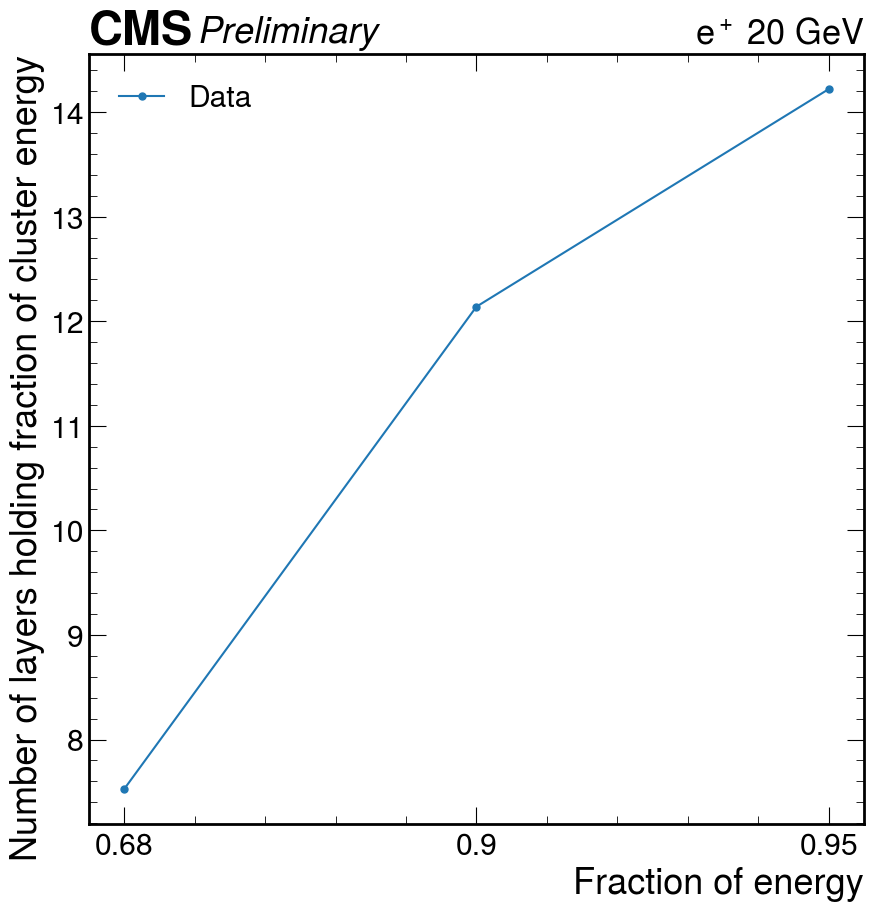

In [92]:
fig = makePlotProfile_fctFraction(20, ["data"])

In [90]:
fig.axes[0].xaxis.major.formatter.func

functools.partial(<function Axis._format_with_dict at 0x7fe05a058f40>, {0.5: '0.68', 1.5: '0.9', 2.5: '0.95'})